In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
from pytorch_eo.utils import download_url
from os.path import exists

url = 'https://firebasestorage.googleapis.com/v0/b/models-universe.appspot.com/o/public%2Fresnet18_ssl.pth?alt=media&token=98042c7a-90bb-4bfb-8bb8-6a10498fa21b'
path_to_file = 'resnet18_ssl.pth'

if not exists(path_to_file):
	download_url(url, path_to_file)

resnet18_ssl = torch.load(path_to_file)

resnet18_ssl

/home/juan/miniconda3/lib/python3.9/site-packages/torch/serialization.py:587: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


RecursiveScriptModule(
  original_name=FeatureListNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (act1): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (act1): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      (act2): RecursiveScriptModule(original_name=ReLU)
    )
    (1): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (act1): RecursiveScriptModule(original_name=

In [3]:
out = resnet18_ssl(torch.randn(32, 3, 224, 224))

for o in out:
	print(o.shape)

torch.Size([32, 64, 112, 112])
torch.Size([32, 64, 56, 56])
torch.Size([32, 128, 28, 28])
torch.Size([32, 256, 14, 14])
torch.Size([32, 512, 7, 7])


In [4]:
from pytorch_eo.datasets.eurosat import EuroSAT
from pytorch_eo.utils.sensors import S2

ds = EuroSAT(batch_size=25, bands=S2.RGB, verbose=True, label_ratio=0.01)

ds.setup()

data already extracted !
Number of images: 27000
training samples 16200
validation samples 5400
test samples 5400
training samples after label ratio filtering: 162


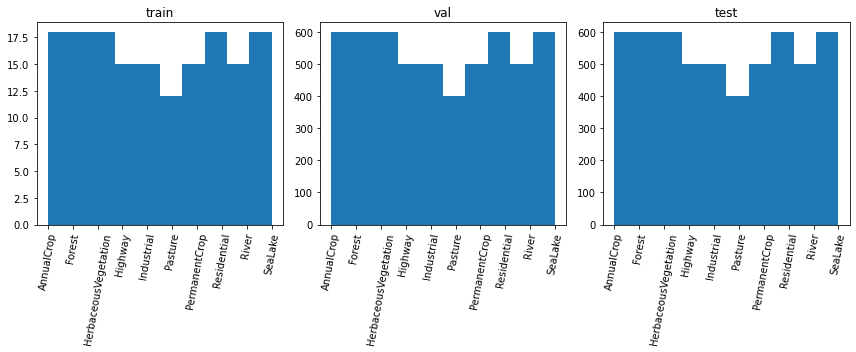

In [5]:
# label distribution

import numpy as np 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(1,3,1)
ax.hist(ds.train_df.label, bins=len(ds.classes))
ax.set_title('train')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
ax = plt.subplot(1,3,2)
ax.hist(ds.val_df.label, bins=len(ds.classes))
ax.set_title('val')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
ax = plt.subplot(1,3,3)
ax.hist(ds.test_df.label, bins=len(ds.classes))
ax.set_title('test')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
plt.tight_layout()
plt.show()

In [13]:
import timm
import torch
from einops import rearrange

class MyModel(torch.nn.Module):
    def __init__(self, backbone=None, num_classes=10, pretrained=None, in_chans=3, max_value=4000, fine_tune=True):
        super().__init__()
        if backbone is None:
            self.backbone = timm.create_model(
                'resnet18',
                pretrained=pretrained,
                in_chans=in_chans,
                features_only=True
            )
        else:
            self.backbone = torch.load(backbone)

        self.fine_tune = fine_tune
        if not self.fine_tune:
            for params in self.backbone.parameters():
                params.requieres_grad = False

        self.fc = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d((1, 1)),
            torch.nn.Flatten(),
            torch.nn.Linear(512, num_classes)
        )
        self.max_value = max_value

    def forward(self, x):
        x = x['image']
        x = rearrange(x, 'b h w c -> b c h w')
        x = x / self.max_value
        if self.fine_tune:
            f = self.backbone(x)[-1]
        else:
            with torch.no_grad():
                f = self.backbone(x)[-1]
        return self.fc(f)

In [14]:
import pytorch_lightning as pl
from pytorch_eo.tasks.classification import ImageClassification

def train(model, label_ratio=0.01):
    ds = EuroSAT(batch_size=32, bands=S2.RGB, label_ratio=label_ratio)
    task = ImageClassification(model)
    trainer = pl.Trainer(
        gpus=1,
        precision=16,
        max_epochs=20,
    )
    trainer.fit(task, ds)
    return trainer.test()

In [9]:
model = MyModel()
train(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MyModel          | 11.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.46129629015922546, 'test_loss': 1.5485650300979614}
--------------------------------------------------------------------------------


[{'test_acc': 0.46129629015922546, 'test_loss': 1.5485650300979614}]

In [10]:
model = MyModel(pretrained='imagenet')
train(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MyModel          | 11.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.619259238243103, 'test_loss': 1.541683316230774}
--------------------------------------------------------------------------------


[{'test_acc': 0.619259238243103, 'test_loss': 1.541683316230774}]

In [11]:
model = MyModel(backbone='resnet18_ssl.pth')
train(model)

/home/juan/miniconda3/lib/python3.9/site-packages/torch/serialization.py:587: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MyModel          | 11.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8474074006080627, 'test_loss': 0.5077487230300903}
--------------------------------------------------------------------------------


[{'test_acc': 0.8474074006080627, 'test_loss': 0.5077487230300903}]

In [12]:
model = MyModel(backbone='resnet18_ssl.pth', freeze=True)
train(model)

/home/juan/miniconda3/lib/python3.9/site-packages/torch/serialization.py:587: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | MyModel          | 11.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7927777767181396, 'test_loss': 1.0843415260314941}
--------------------------------------------------------------------------------


[{'test_acc': 0.7927777767181396, 'test_loss': 1.0843415260314941}]

We performed some experiments, and these are the results:

![](./pics/eurosat_ssl.png)